# Arabic Poetry Tashbeeh Classification with AraBERT
Detect tashbeeh (similes) in Arabic poems using a fine-tuned BERT model.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Load Dataset

In [13]:
df = pd.read_csv("merged_poems_dataset_cleaned.csv")
df.head()

,النص,label
0,فبات على البرج المطل، كأنما يلاحظ منه فرقدا ثم...,1
1,غردت على فنن فأسعد شجوها ورق يجبن كما استجاب ا...,1
2,وإذا ما انبعثت أجري إليها كنت كالمبتغي مع الشم...,1
3,وكأنما أبدى لنا بمدامه وجماله صاع العزيز ويوسفا,1
4,فلا تسقطنكم بعدها آل مالك شرار أحاديث الرجال و...,0


## Train / Validation / Test Split

In [14]:
train_df, temp_df = train_test_split(df, test_size=0.95, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.98, stratify=temp_df['label'], random_state=42)

## Tokenization

In [15]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_example(example):
    return tokenizer(example['النص'], truncation=True, padding="max_length")

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

train_ds = train_ds.map(tokenize_example, batched=True)
val_ds = val_ds.map(tokenize_example, batched=True)
test_ds = test_ds.map(tokenize_example, batched=True)

train_ds = train_ds.remove_columns(['النص'])
val_ds = val_ds.remove_columns(['النص'])
test_ds = test_ds.remove_columns(['النص'])

Map:   0%|          | 0/2926 [00:00<?, ? examples/s]

Map:   0%|          | 0/1112 [00:00<?, ? examples/s]

Map:   0%|          | 0/54490 [00:00<?, ? examples/s]

## Load Model

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Evaluation Metrics

In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

## Training Configuration

In [18]:
training_args = TrainingArguments(
    output_dir="./cls_model",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

## Initialize Trainer

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

/home/faisal/anaconda3/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the Model

In [20]:
trainer.train()

  0%|          | 0/3660 [00:00<?, ?it/s]

{'loss': 0.4265, 'grad_norm': 17.3127384185791, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/278 [00:00<?, ?it/s]

{'eval_loss': 0.285860151052475, 'eval_accuracy': 0.9406474820143885, 'eval_runtime': 158.3431, 'eval_samples_per_second': 7.023, 'eval_steps_per_second': 1.756, 'epoch': 1.0}
{'loss': 0.2949, 'grad_norm': 0.07817870378494263, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/278 [00:00<?, ?it/s]

{'eval_loss': 0.2817794680595398, 'eval_accuracy': 0.9442446043165468, 'eval_runtime': 144.043, 'eval_samples_per_second': 7.72, 'eval_steps_per_second': 1.93, 'epoch': 2.0}
{'loss': 0.2376, 'grad_norm': 0.09545618295669556, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/278 [00:00<?, ?it/s]

{'eval_loss': 0.2678791284561157, 'eval_accuracy': 0.9496402877697842, 'eval_runtime': 144.536, 'eval_samples_per_second': 7.694, 'eval_steps_per_second': 1.923, 'epoch': 3.0}
{'loss': 0.1906, 'grad_norm': 0.07101452350616455, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/278 [00:00<?, ?it/s]

{'eval_loss': 0.26393359899520874, 'eval_accuracy': 0.9550359712230215, 'eval_runtime': 180.1261, 'eval_samples_per_second': 6.173, 'eval_steps_per_second': 1.543, 'epoch': 4.0}
{'loss': 0.1409, 'grad_norm': 0.0436193086206913, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/278 [00:00<?, ?it/s]

{'eval_loss': 0.26660653948783875, 'eval_accuracy': 0.9523381294964028, 'eval_runtime': 183.7666, 'eval_samples_per_second': 6.051, 'eval_steps_per_second': 1.513, 'epoch': 5.0}
{'train_runtime': 7423.9988, 'train_samples_per_second': 1.971, 'train_steps_per_second': 0.493, 'train_loss': 0.2581058773186689, 'epoch': 5.0}


TrainOutput(global_step=3660, training_loss=0.2581058773186689, metrics={'train_runtime': 7423.9988, 'train_samples_per_second': 1.971, 'train_steps_per_second': 0.493, 'train_loss': 0.2581058773186689, 'epoch': 5.0})

## Evaluate on Test Set and Save Confusion Matrix

  0%|          | 0/13623 [00:00<?, ?it/s]

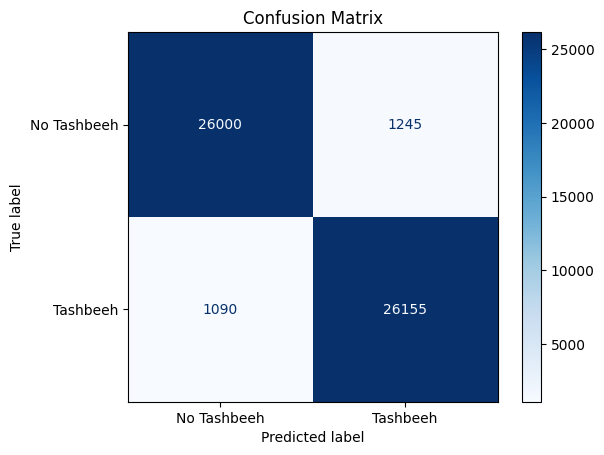

In [21]:
# Get predictions
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
true = preds_output.label_ids

# Save confusion matrix
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tashbeeh', 'Tashbeeh'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

## Save Prediction Results and Show Examples

In [22]:
# Save results to CSV
test_df = test_df.reset_index(drop=True)
test_df['predicted'] = preds
test_df['correct'] = test_df['label'] == test_df['predicted']
test_df.to_csv("predicted_poems.csv", index=False)

# Show examples
print("✅ True Positives:")
print(test_df[(test_df['label'] == 1) & (test_df['predicted'] == 1)].head(3))
print("\n❌ False Positives:")
print(test_df[(test_df['label'] == 0) & (test_df['predicted'] == 1)].head(3))
print("\n❌ False Negatives:")
print(test_df[(test_df['label'] == 1) & (test_df['predicted'] == 0)].head(3))

✅ True Positives:
                                                النص  label  predicted  \
2  لقد حسنت كما حسنت أيادي أبي العباس في الدهر ال...      1          1   
3     كأني إذ أكفكف دمع عيني وأنهاها أقول لها: هريقي      1          1   
5  عوادل عوجا عن أناس كأنما ترى بهم جمع الصقالبة ...      1          1   

   correct  
2     True  
3     True  
5     True  

❌ False Positives:
                                                  النص  label  predicted  \
8    رأوا أنه من فر من زحف مثلهم يكن حطبا للنار فيم...      0          1   
87   أرجو لكم أن تكونوا في مودتكم كلبا كورهاء تقلي ...      0          1   
100      بجوز كحق الهاجرية لزه بأطراف عود الفارسي لطيم      0          1   

     correct  
8      False  
87     False  
100    False  

❌ False Negatives:
                                                 النص  label  predicted  \
13  خالي الذي غصب الملوك نفوسهم وإليه كان حباء جفن...      1          0   
27  وتراه في طلم الوغى فتخاله قمرا يكر على الرجال ...      1          0   
39 